# Artificial Intelligence
## UEMH3073 / UECS2053 / UECS2153

# Lab 2: Genetic Algorithm

This notebook is an assignment requiring you to investigate the Travelling Salesman Problem. Guidance is provided so you can understand what needs to be done for this assignment as you follow through this lab. Convenience classes and functions/ methods are provided.

You will encounter #TODO in the code cells explaining tasks you need to complete. In other words, you will need to write codes and accomplish the #TODO tasks so that the genetic algorithm functions well and runs correctly. Look for "Replacement starts here" and "Replacement ends here" to know the parts of the codes requiring your inputs.
    

The #TODO tasks and their marks distribution are as follows:

a. #TODO1 (10 marks) in the Population Initialization function. You will read a set of cities from the filename when creating an initial population.

b. #TODO2 (10 marks) in the Parent Selection function. You will replace a dummy parent selection function with Tournament Selection.

c. #TODO3 (10 marks) in the Parent Selection function. You will replace a dummy parent selection function with Proportional Selection.

d. #TODO4 (10 marks) in the Survival Selection function. You will replace the dummy survival selection function with Merge, Sort & Truncate.
    
e. #TODO5 (10 marks) in the Crossover function. You will replace the dummy crossover function the Partially Mapped Crossover approach.

f. #TODO6 (10 marks) in the Mutation function. You will replace the dummy mutation function with Insertion Mutation approach.

g. #TODO7 (10 marks) in Performance Evaluation. You will present performance evaluation for the different Parent Selection functions.

Marks are also given for: Report Presentation and Formatting (15%) and Code Quality and Comments (15%). More details about this notebook and assignemnt are provided in your lab sheet.

## An Overview of the Travelling Salesman Problem

In the travelling salesman problem, a salesperson wish to find the shortest path that passes through all cities s/he wishes to visit given the coordinates of a set of cities. The salesperson should visit each of the cities once only, and so:

a. Each path consists all cities in the set.

b. Each path visits each of the cities once only. So, none of the cities are visited more than once.

## Imports

In [17]:
%matplotlib inline

# Please add more imports if you need them 

import random
import time
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint as print 

## Convenience Classes

### City

The City class, which represents a city, possesses the properties of the city and has functions/ methods used for calculating the distance between the city and another city. Each path, represented by a chromosome, is formed by a set of cities.   

In [3]:
class City:
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def __repr__(self):
        return f"City({self.name}, {self.x}, {self.y})"

### Fitness

The Fitness class, which represents the fitness function, possesses the properties of a path and has functions/methods used for calculating the fitness value of the path, which is based on the distance of the path.

In [4]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = None
        self.fitness = None

    def routeDistance(self):
        if self.distance == None:
            pathDistance = 0.0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i+1 < len(self.route):
                    toCity = self.route[i+1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    def routeFitness(self):
        if self.fitness == None:
        # Fitness function (Simple division) that uses a simple
        # division that divides one by the distance of the path
            self.fitness = 1 / float(self.routeDistance())
            # Note: You must ensure a division by zero does not occur
        return self.fitness

## Population Initialization  

The population initialization function (or method) performs random initialization. This creates an initial population with completely random chromosomes (or solutions). There are three functions related to population initialization.

The first function is genCityList() which generates a set of cities from a file.  

In [5]:
def genCityList(filename):
    cityList = []  

    with open(filename, 'r') as file:  # Open the file in read mode
        next(file)  # Skip the header line in the file

        # Iterate through each line in the file
        for line in file:
            # Split the line by commas, strip any extra spaces, and unpack the values
            name, x, y = map(str.strip, line.strip().split(','))

            # Create a City object and append it to the cityList
            cityList.append(City(name, int(x), int(y)))

    return cityList  

The second function is createRoute() which generates a random route (chromosome) from a set of City instances.

In [6]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

The third function is initialPopulation() which calls the second function repeatedly to create an initial population (a list of routes).

In [7]:
def initialPopulation(popSize, cityList):
    population = []
    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

You can run the above functions using the sample runs below. To do so, simply change the cell type from Markdown to Code.

Sample run 1 initializes 10 cities in cityList as follows:

cityList = genCityList('cities10.txt')
print(cityList)

Sample run 2 initializes 10 cities in cityList and creates a population with three routes as follows:

cityList = genCityList('cities10.txt')
population = initialPopulation(3, cityList)
print(population)

## Selection

Parents selection selects chromosomes with high fitness values from a population. Survivor selection selects chromosomes with higher fitness values to form the population of the next generation. The population size is len(population), so we have len(population) in this population.

### Parent Selection

There are three implementations for parent selection. The first parentSelection() performs random selection.

In [8]:
def parentSelection(population, poolSize=None):
    if poolSize == None:
        poolSize = len(population)

    matingPool = []

    for i in range(0, poolSize):
        fitness = Fitness(population[i]).routeFitness()
        matingPool.append(random.choice(population))

    return matingPool

The second parentSelection() performs Tournament Selection.

In [9]:
def tournamentSelection(population, poolSize=None):

    if poolSize == None:
        poolSize = len(population)

    matingPool = []
    tournamentSize = 3

    #Using the while loop to ensure mating pool = poolsize
    while len(matingPool) < poolSize:
        # Randomly select individuals for the tournament
        tournament = random.sample(population, tournamentSize)

        # Evaluate fitness for each individual in the tournament
        fitness_scores = []
        for individual in tournament:
            fitness = Fitness(individual).routeFitness()
            fitness_scores.append((individual, fitness))

        # Select the individual with the highest fitness
        winner = max(fitness_scores, key=lambda x: x[1])[0]

        # Ensure the winner is not already in the mating pool
        if winner not in matingPool:
            matingPool.append(winner)

    return matingPool

The third parentSelection() performs Proportional Selection.

In [10]:
def proportionalSelection(population, poolSize=None):

    if poolSize is None:
        poolSize = len(population)

    # Create list to store individuals for the mating pool
    matingPool = []

    # Calculate fitness for each individual and compute total fitness
    fitness_scores = []
    for individual in population:
        fitness = Fitness(individual).routeFitness()
        fitness_scores.append((individual, fitness))

    total_fitness = 0
    # Iterate over each tuple in fitness_scores
    for individual, fitness in fitness_scores:
        # Add the fitness of the current individual to total_fitness
        total_fitness += fitness

    # Initialize an empty list to store the probabilities
    probabilities = []
    # Iterate over each tuple in fitness_scores
    for individual, fitness in fitness_scores:
        # Calculate the probability of the individual
        probability = fitness / total_fitness
        # Append the tuple (individual, probability) to the probabilities list
        probabilities.append((individual, probability))

    while len(matingPool) < poolSize:
        pick_value = random.random()
        cumulative_probability = 0

        for individual, probability in probabilities:
            cumulative_probability += probability
            if pick_value < cumulative_probability:
                # Ensure the individual is not already in the mating pool
                if individual not in matingPool:
                    matingPool.append(individual)
                break

    return matingPool

### Survival Selection

In [11]:
def survivorSelection(population, eliteSize):
    # Create list to store individuals for elites, and individuals and their fitness values
    elites = []

    # Calculate fitness for each individual in the population
    for individual in population:
        fitness = Fitness(individual).routeFitness()
        elites.append((individual, fitness))

    # Sort based on fitness (higher fitness is better)
    elites.sort(key=lambda x: x[1], reverse=True)

    # Keep only the top eliteSize individuals (Truncate)
    elites = elites[:eliteSize]

    # Extract the individuals from the sorted list of tuples
    elites = [individual for individual, fitness in elites]

    return elites

You can run the above functions using the sample runs below. To do so, simply change the cell type from Markdown to Code.

Sample run 1 initializes 10 cities in cityList, creates a population with four routes, and creates a pool of parents as follows:

population = initialPopulation(4, genCityList('cities10.txt'))
matingpool = parentSelection(population, 4)
print('Initial population')
print(population)
print('Mating pool')
print(matingpool)

Sample run 2 initializes 10 cities in cityList, creates a population with four routes, select an elite chromosome as follows:

population = initialPopulation(4, genCityList('cities10.txt'))
elites = survivorSelection(population, 1)
print('Initial population')
print(population)
print('Selected elites')
print(elites)

## Crossover


Crossover selects two parents, crossover the genetic materials of the parents, and produce one or more children. In the Travelling Salesman Problem, each travelling path must be valid. Each path consists all cities in the set, and each path visits each of the cities once only. So, none of the cities are visited more than once. Exchanging parts of two chromosomes tend to produce invalid paths. As an example, Parent 1 is [2 1 0 7 3 5 4 6] and Parent 2 is [6 1 0 5 2 3 4 7]. One point crossover at midpoint generates Child 1 [2 1 0 7 2 3 4 7] and Child 2 [6 1 0 5 3 5 4 6]. Both children are invalid paths.     

In [12]:
import random

def crossover(parent1, parent2):
    length = len(parent1)

    # Randomly select two crossover points and ensuring they are in order
    crossover_point1, crossover_point2 = sorted(random.sample(range(length), 2))
    
    # Initialize children as lists with None values to hold genes
    child1 = [None] * length
    child2 = [None] * length

    # Copy crossover section from parents to children
    child1[crossover_point1:crossover_point2] = parent2[crossover_point1:crossover_point2]
    child2[crossover_point1:crossover_point2] = parent1[crossover_point1:crossover_point2]

    # Create a mapping for the crossover section
    mapping1 = {parent2[i]: parent1[i] for i in range(crossover_point1, crossover_point2)}
    mapping2 = {parent1[i]: parent2[i] for i in range(crossover_point1, crossover_point2)}

    # Helper function to find the mapped gene
    def find_mapped_gene(mapping, gene):
        while gene in mapping:
            gene = mapping[gene]
        return gene

    # Function to fill in the remaining slots in the child with genes from the other parent
    def fill_remaining(parent, child, mapping):
        for i in range(len(child)):
            if child[i] is None:  # Check only empty slots
                gene = parent[i]
                if gene in mapping:
                    gene = find_mapped_gene(mapping, gene)
                while gene in child:
                    gene = find_mapped_gene(mapping, gene)
                child[i] = gene

    # Use the mappings to fill in the missing genes
    fill_remaining(parent1, child1, mapping1)
    fill_remaining(parent2, child2, mapping2)

    return child1, child2

Crossover selects two parents from the mating pool to produce a new generation of the same size.

In [13]:
def breedPopulation(matingpool):
    children = []

    # Choosing parents in their order of presence in the mating pool. Choosing parents
    # in a random manner is possible.

    for i in range(1, len(matingpool), 2):
        child1, child2 = crossover(matingpool[i-1], matingpool[i])
        children.append(child1)
        children.append(child2)

    return children

You can run the above functions using the sample run below. To do so, simply change the cell type from Markdown to Code. The sample run initializes 2 chromosomes in the population, and performs crossover among the two parents.

population = initialPopulation(2, genCityList('cities10.txt'))
parent1, parent2 = population
child1, child2 = crossover(parent1, parent2)
print('Parents')
print(parent1)
print(parent2)
print('Children')
print(child1)
print(child2)

## Mutation

Mutation mutates a single chromosome to get a mutated chromosome so that genetic algorithm can converge to a shorter path quickly. In the Travelling Saleman Problem, a mutated chromosome must be a valid path. As an example, the insertion mutation randomly inserts a single gene in the [1 2 3 4 5 6 7 8 9 10] chromosome to generate the [1 2 4 5 6 7 3 8 9 10] mutated chromosome. Step 1: select a gene randomly, Step 2: insert this gene into a randomly selected location.

In [14]:
def mutate(route, mutationProbability):
    # Make a copy of the route to avoid modifying the original route
    mutated_route = route[:]
    length = len(mutated_route)

    for i in range(length):
        # Determine if a mutation should occur based on the mutation probability
        if random.random() < mutationProbability:
            # Select a random position in the route to remove a city
            remove_index = random.randint(0, length - 1)
            city = mutated_route.pop(remove_index)

            # Select a new random position to insert the city
            insert_index = random.randint(0, length - 1)
            mutated_route.insert(insert_index, city)

    return mutated_route

Mutation runs over the entire population and mutates each chromosome in the population with a small mutationProbability.

In [15]:
def mutation(population, mutationProbability):
    mutatedPopulation = []
    for i in range(0, len(population)):
        mutatedIndividual = mutate(population[i], mutationProbability)
        mutatedPopulation.append(mutatedIndividual)
    return mutatedPopulation

You can run the above functions using the sample run below. To do so, simply change the cell type from Markdown to Code. The sample run initializes a route comprised of 10 cities in cityList, and then mutates it as follows:

route = genCityList('cities10.txt')
mutated = mutate(route, 1)  # Give a pretty high chance for mutation
print('Original route')
print(route)
print('Mutated route')
print(mutated)

## Running One Generation (or Interation)

Here, we run one generation of genetic algorithm.

In [16]:
def oneGeneration(population, eliteSize, mutationProbability):

    # First we preserve the elites
    elites = survivorSelection(population, eliteSize)

    # Then we calculate what our mating pool size should be and generate
    # the mating pool
    poolSize = len(population) - eliteSize
    matingpool = parentSelection(population, poolSize)

    # Then we perform crossover on the mating pool
    children = breedPopulation(matingpool)

    # We combine the elites and children into one population
    new_population = elites + children

    # We mutate the population
    mutated_population = mutation(new_population, mutationProbability)

    return mutated_population

You can run the above functions using the sample run below. To do so, simply change the cell type from Markdown to Code. The sample run initializes a population comprised of 5 chromosomes based on 10 cities in cityList, and then run one generation (or iteration) of genetic algorithm as follows:

population = initialPopulation(5, genCityList('cities10.txt'))
eliteSize = 1
mutationProbability = 0.01
new_population = oneGeneration(population, eliteSize, mutationProbability)
print('Initial population')
print(population)
print('New population')
print(new_population)

## Running Many Generations (or Interations)

Streaming output truncated to the last 5000 lines.
 'City(458, 35, 46): City(85, 58, 38), City(288, 22, 95): City(351, 77, 30), '
 'City(368, 57, 81): City(278, 91, 31), City(478, 96, 29): City(212, 84, 85), '
 'City(85, 58, 38): City(282, 27, 23), City(351, 77, 30): City(296, 60, 50), '
 'City(343, 79, 6): City(198, 37, 50), City(278, 91, 31): City(338, 70, 32), '
 'City(106, 59, 0): City(329, 23, 83), City(73, 64, 15): City(470, 44, 64), '
 'City(265, 29, 21): City(415, 75, 71), City(497, 12, 98): City(26, 96, 59), '
 'City(282, 27, 23): City(89, 89, 72), City(198, 37, 50): City(134, 68, 40), '
 'City(338, 70, 32): City(13, 69, 80), City(299, 70, 70): City(115, 81, 94), '
 'City(301, 68, 62): City(249, 13, 87), City(470, 44, 64): City(309, 79, 91), '
 'City(26, 96, 59): City(205, 20, 81), City(467, 2, 24): City(299, 70, 70), '
 'City(434, 79, 99): City(324, 15, 20), City(435, 25, 75): City(82, 38, 99), '
 'City(13, 69, 80): City(259, 76, 54), City(115, 81, 94): City(87, 27, 0), '
 'C

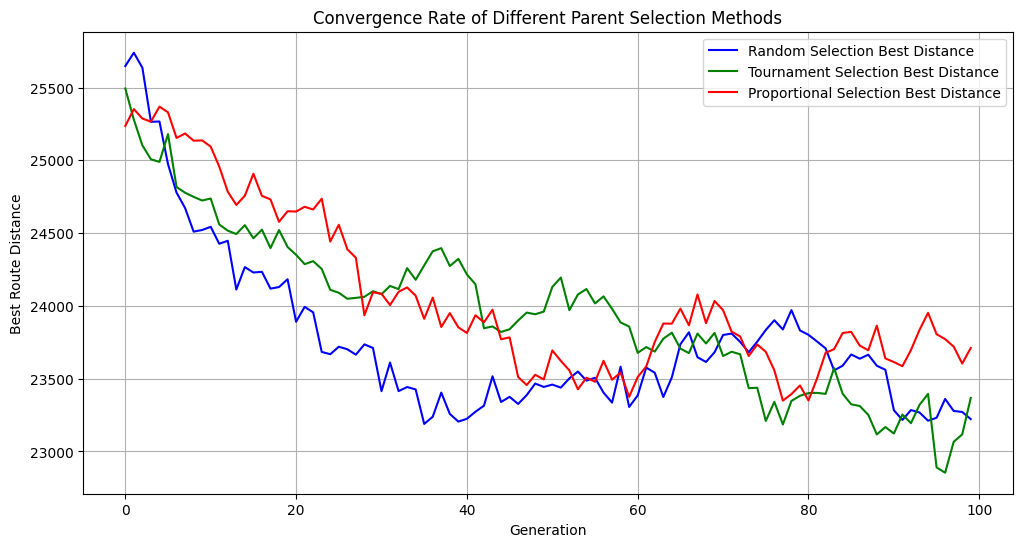

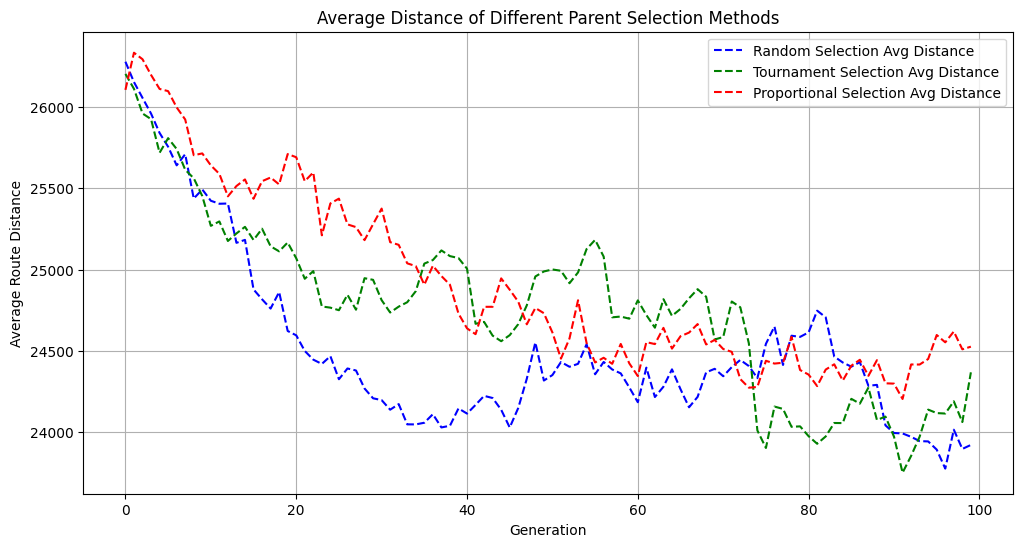

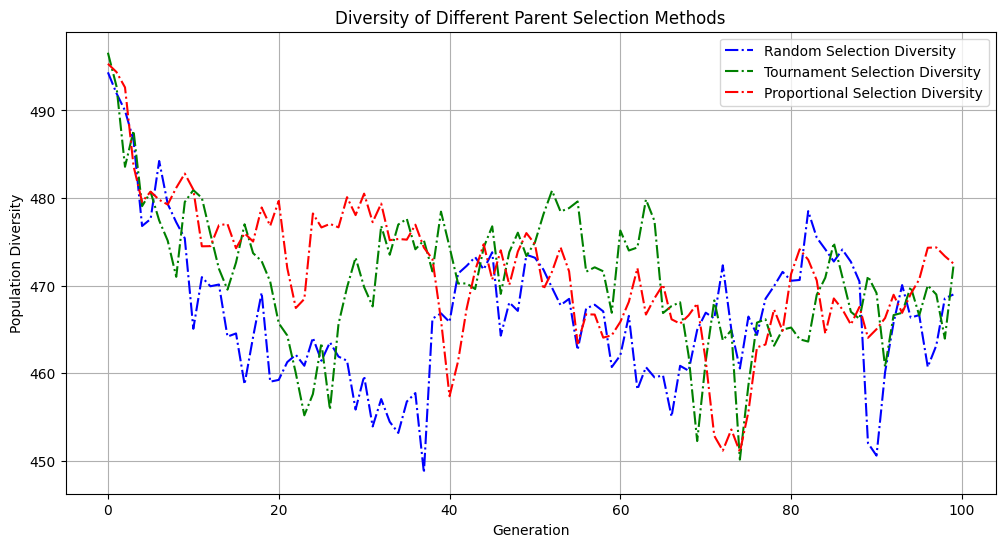

'Execution Time for Random Selection: 142.86 seconds'
'Execution Time for Tournament Selection: 135.17 seconds'
'Execution Time for Proportional Selection: 134.79 seconds'
'Best distance using Random Selection: 23189.28'
'Best distance using Tournament Selection: 22854.00'
'Best distance using Proportional Selection: 23349.39'
'\nFinal Metrics for Each Selection Method:'
'\nRandom Selection:'
'  Best Distance: 23189.28'
'  Average Distance (last gen): 23922.84'
'  Diversity (last gen): 468.98'
'\nTournament Selection:'
'  Best Distance: 22854.00'
'  Average Distance (last gen): 24368.81'
'  Diversity (last gen): 472.17'
'\nProportional Selection:'
'  Best Distance: 23349.39'
'  Average Distance (last gen): 24526.50'
'  Diversity (last gen): 472.52'


In [ ]:
import time

filename = 'cities500.txt'
num_generations = 100
popSize = 20
eliteSize = 5
mutationProbability = 0.01

# Function to collect various performance metrics
def evaluate_selection_method(selection_function, num_generations, popSize, eliteSize, mutationProbability, filename):
    cityList = genCityList(filename)
    best_distances = []
    avg_distances = []
    diversity = []  # To store diversity of the population
    start_time = time.time()  # To measure execution time

    population = initialPopulation(popSize, cityList) # Initialize the population with random solutions
    for _ in range(num_generations):
        # Simulate one generation (selection, crossover, mutation)
        population = oneGeneration(population, eliteSize, mutationProbability)

        # Calculate the fitness (distance) of each solution in the population
        distances = [Fitness(p).routeDistance() for p in population]
        best_distances.append(min(distances)) # Store the best (shortest) distance found in this generation
        avg_distances.append(np.mean(distances)) # Store the average distance of the population

        # Calculate diversity (e.g., average pairwise distance)
        pairwise_distances = []
        for i in range(len(population)):
            for j in range(i + 1, len(population)):
                # Calculate the number of different cities between two solutions
                pairwise_distances.append(np.sum(np.array(population[i]) != np.array(population[j])))
        # Store the average pairwise distance as a measure of diversity
        diversity.append(np.mean(pairwise_distances) if pairwise_distances else 0)

    # Calculate the total execution time
    execution_time = time.time() - start_time

    return best_distances, avg_distances, diversity, execution_time

# Evaluate each selection method
random_best_distances, random_avg_distances, random_diversity, random_time = evaluate_selection_method(parentSelection, num_generations, popSize, eliteSize, mutationProbability, filename)
tournament_best_distances, tournament_avg_distances, tournament_diversity, tournament_time = evaluate_selection_method(tournamentSelection, num_generations, popSize, eliteSize, mutationProbability, filename)
proportional_best_distances, proportional_avg_distances, proportional_diversity, proportional_time = evaluate_selection_method(proportionalSelection, num_generations, popSize, eliteSize, mutationProbability, filename)

# Plot convergence rate
plt.figure(figsize=(12, 6))
plt.plot(random_best_distances, label='Random Selection Best Distance', color='blue', linestyle='-')
plt.plot(tournament_best_distances, label='Tournament Selection Best Distance', color='green', linestyle='-')
plt.plot(proportional_best_distances, label='Proportional Selection Best Distance', color='red', linestyle='-')
plt.xlabel('Generation')
plt.ylabel('Best Route Distance')
plt.title('Convergence Rate of Different Parent Selection Methods')
plt.legend()
plt.grid(True)
plt.show()

# Plot average distance
plt.figure(figsize=(12, 6))
plt.plot(random_avg_distances, label='Random Selection Avg Distance', color='blue', linestyle='--')
plt.plot(tournament_avg_distances, label='Tournament Selection Avg Distance', color='green', linestyle='--')
plt.plot(proportional_avg_distances, label='Proportional Selection Avg Distance', color='red', linestyle='--')
plt.xlabel('Generation')
plt.ylabel('Average Route Distance')
plt.title('Average Distance of Different Parent Selection Methods')
plt.legend()
plt.grid(True)
plt.show()

# Plot diversity
plt.figure(figsize=(12, 6))
plt.plot(random_diversity, label='Random Selection Diversity', color='blue', linestyle='-.')
plt.plot(tournament_diversity, label='Tournament Selection Diversity', color='green', linestyle='-.')
plt.plot(proportional_diversity, label='Proportional Selection Diversity', color='red', linestyle='-.')
plt.xlabel('Generation')
plt.ylabel('Population Diversity')
plt.title('Diversity of Different Parent Selection Methods')
plt.legend()
plt.grid(True)
plt.show()

# Print execution times and best distances
print(f"Execution Time for Random Selection: {random_time:.2f} seconds")
print(f"Execution Time for Tournament Selection: {tournament_time:.2f} seconds")
print(f"Execution Time for Proportional Selection: {proportional_time:.2f} seconds")

print(f"Best distance using Random Selection: {min(random_best_distances):.2f}")
print(f"Best distance using Tournament Selection: {min(tournament_best_distances):.2f}")
print(f"Best distance using Proportional Selection: {min(proportional_best_distances):.2f}")

# Print final metrics
print("\nFinal Metrics for Each Selection Method:")
print(f"\nRandom Selection:")
print(f"  Best Distance: {min(random_best_distances):.2f}")
print(f"  Average Distance (last gen): {random_avg_distances[-1]:.2f}")
print(f"  Diversity (last gen): {random_diversity[-1]:.2f}")

print(f"\nTournament Selection:")
print(f"  Best Distance: {min(tournament_best_distances):.2f}")
print(f"  Average Distance (last gen): {tournament_avg_distances[-1]:.2f}")
print(f"  Diversity (last gen): {tournament_diversity[-1]:.2f}")

print(f"\nProportional Selection:")
print(f"  Best Distance: {min(proportional_best_distances):.2f}")
print(f"  Average Distance (last gen): {proportional_avg_distances[-1]:.2f}")
print(f"  Diversity (last gen): {proportional_diversity[-1]:.2f}")
